In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/plants-disease-detection1/Plant disease detection/Corn___Northern_Leaf_Blight/image_(293).JPG
/kaggle/input/plants-disease-detection1/Plant disease detection/Corn___Northern_Leaf_Blight/image_(371).JPG
/kaggle/input/plants-disease-detection1/Plant disease detection/Corn___Northern_Leaf_Blight/image_(241).JPG
/kaggle/input/plants-disease-detection1/Plant disease detection/Corn___Northern_Leaf_Blight/image_(855).JPG
/kaggle/input/plants-disease-detection1/Plant disease detection/Corn___Northern_Leaf_Blight/image_(144).JPG
/kaggle/input/plants-disease-detection1/Plant disease detection/Corn___Northern_Leaf_Blight/image_(915).JPG
/kaggle/input/plants-disease-detection1/Plant disease detection/Corn___Northern_Leaf_Blight/image_(276).JPG
/kaggle/input/plants-disease-detection1/Plant disease detection/Corn___Northern_Leaf_Blight/image_(290).JPG
/kaggle/input/plants-disease-detection1/Plant disease detection/Corn___Northern_Leaf_Blight/image_(858).jpg
/kaggle/input/plants-disease

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn

# Set image dimensions, batch size, and dataset directory
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
dataset_dir = "/kaggle/input/plants-disease-detection1/Plant disease detection"  # Replace with the path to your dataset

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True  # Enables faster training when input sizes don't vary

print(f"Using device: {device}")


Using device: cuda


In [3]:
# Define transforms: grayscale conversion, augmentation, normalization
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to grayscale and expand to 3 channels
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop((IMG_HEIGHT, IMG_WIDTH), scale=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=(0.5, 1.5)),  # Augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Standardization for grayscale (mean and std for each channel)
])

val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to grayscale
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Same normalization
])

# Load dataset using ImageFolder
full_dataset = datasets.ImageFolder(dataset_dir, transform=train_transforms)

# Split dataset into training and validation (80% train, 20% validation)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply validation transforms
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_transforms

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Print class names
class_names = full_dataset.classes
print(f"Classes: {class_names}")


Classes: ['Corn___Common_Rust', 'Corn___Gray_Leaf_Spot', 'Corn___Northern_Leaf_Blight', 'Corn_healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato_healthy', 'Rice___Brown_Spot', 'Rice___Leaf_Blast', 'Rice___Neck_Blast', 'Rice_healthy', 'Sugarcane_Bacterial Blight', 'Sugarcane_Red Rot', 'Sugarcane_healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_healthy', 'Wheat___Brown_Rust', 'Wheat___Yellow_Rust', 'Wheat_healthy']


In [4]:
# Define the PlantDiseaseClassifier model using EfficientNet-B0
class PlantDiseaseClassifier(nn.Module):
    def __init__(self, num_classes):
        super(PlantDiseaseClassifier, self).__init__()
        # Load EfficientNetB0 model
        self.base_model = models.efficientnet_b0(pretrained=True)
        
        # Modify classifier to match the number of classes
        num_ftrs = self.base_model.classifier[1].in_features
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)  # Number of output classes
        )

    def forward(self, x):
        return self.base_model(x)

# Number of classes (adjust this based on your dataset)
num_classes = len(class_names)
model = PlantDiseaseClassifier(num_classes).to(device)

# Define loss function and optimizer (AdamW)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 124MB/s] 


In [5]:
# Function to train the model
def train_model(model, train_loader, val_loader, num_epochs=25):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (preds == labels).sum().item()

        train_acc = correct_train / total_train
        train_loss = running_loss / len(train_loader)
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (preds == labels).sum().item()

        val_acc = correct_val / total_val
        val_loss = val_loss / len(val_loader)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

# Train the model for 25 epochs
train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(
    model, train_loader, val_loader, num_epochs=25)


Epoch 1/25, Train Loss: 0.8555, Train Acc: 0.7440, Val Loss: 0.2562, Val Acc: 0.9045
Epoch 2/25, Train Loss: 0.2745, Train Acc: 0.9013, Val Loss: 0.1880, Val Acc: 0.9269
Epoch 3/25, Train Loss: 0.1856, Train Acc: 0.9337, Val Loss: 0.1628, Val Acc: 0.9374
Epoch 4/25, Train Loss: 0.1498, Train Acc: 0.9459, Val Loss: 0.1646, Val Acc: 0.9398
Epoch 5/25, Train Loss: 0.1211, Train Acc: 0.9562, Val Loss: 0.1526, Val Acc: 0.9495
Epoch 6/25, Train Loss: 0.1041, Train Acc: 0.9636, Val Loss: 0.1524, Val Acc: 0.9489
Epoch 7/25, Train Loss: 0.0907, Train Acc: 0.9686, Val Loss: 0.1718, Val Acc: 0.9489
Epoch 8/25, Train Loss: 0.0787, Train Acc: 0.9725, Val Loss: 0.1553, Val Acc: 0.9497
Epoch 9/25, Train Loss: 0.0671, Train Acc: 0.9777, Val Loss: 0.1656, Val Acc: 0.9516
Epoch 10/25, Train Loss: 0.0629, Train Acc: 0.9778, Val Loss: 0.1625, Val Acc: 0.9535
Epoch 11/25, Train Loss: 0.0536, Train Acc: 0.9826, Val Loss: 0.1693, Val Acc: 0.9525
Epoch 12/25, Train Loss: 0.0582, Train Acc: 0.9801, Val Loss: 0

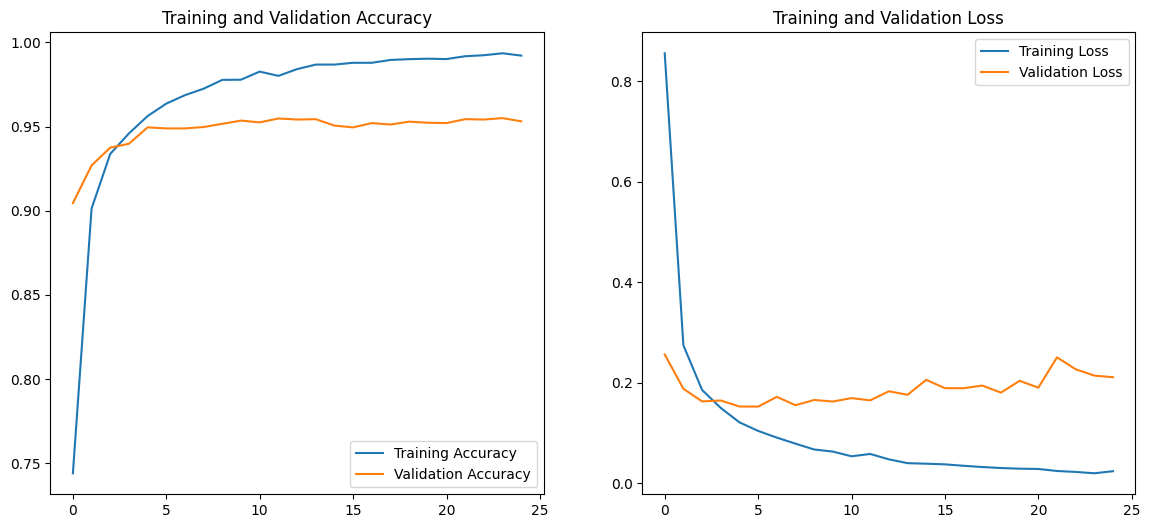

In [6]:
# Plot the training and validation accuracy and loss
def plot_training_history(train_acc, val_acc, train_loss, val_loss):
    epochs_range = range(len(train_acc))

    plt.figure(figsize=(14, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

# Plot training history
plot_training_history(train_acc_history, val_acc_history, train_loss_history, val_loss_history)


In [7]:
import torch

# Step 1: Save the model
def save_model(model, path):
    # Save the state_dict (recommended way)
    torch.save(model.state_dict(), path + '_state_dict.pth')
    
    # Save the entire model (optional)
    torch.save(model, path + '_entire_model.pth')

# After training, call this function to save the model
save_model(model, "/kaggle/working/efficientnet_plant_disease_detection_model")